<a href="https://colab.research.google.com/github/ISAWASHUN/deep-learning/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device 

'cuda'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()                              
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class ConvAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.en = nn.Sequential( #エンコーダー
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )
    self.de = nn.Sequential( #デコーダー
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
        nn.Tanh(),
    )
  def forward(self, x):
    x = self.en(x)
    x = self.de(x)
    return x

In [ ]:
model = ConvAE()
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, _ in train_loader: #labelはいらない
        imgs = imgs.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        running_loss += loss.item()
        loss.backward() #誤差逆伝播
        optimizer.step()
    running_loss /= len(train_loader) #ミニバッチの数で割る
    losses.append(running_loss)
    print("epoch: {}, loss: {}".format(epoch, running_loss,))

epoch: 0, loss: 0.01151353612591823
epoch: 1, loss: 0.005464754804720481
epoch: 2, loss: 0.00467088550205032
epoch: 3, loss: 0.004281474157050252
epoch: 4, loss: 0.004020392599950234
epoch: 5, loss: 0.003833006336167455
epoch: 6, loss: 0.003693717920407653
epoch: 7, loss: 0.0035761451883862417
epoch: 8, loss: 0.003470413300146659
epoch: 9, loss: 0.003386075589681665
epoch: 10, loss: 0.0033219279834379753
epoch: 11, loss: 0.0032702396941681703
epoch: 12, loss: 0.0032333110054334007
epoch: 13, loss: 0.0032000740448633828
epoch: 14, loss: 0.0031701668495933213


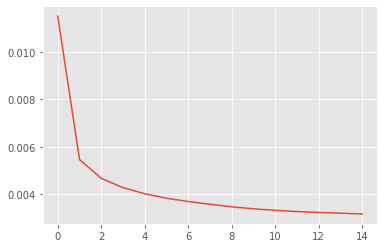

In [ ]:
plt.style.use("ggplot")
plt.plot(losses)

In [ ]:
data_iter = iter(train_loader)

In [ ]:
imgs, _ = data_iter.next()

In [ ]:
img = imgs[0]

In [ ]:
img_permute = img.permute(1,2,0)

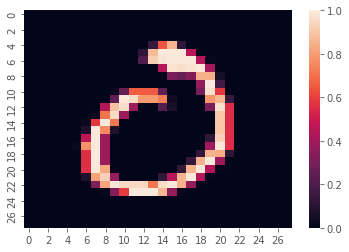

In [ ]:
sns.heatmap(img_permute[:,:,0])

In [ ]:
x_en = model.en(imgs.to(device)) #エンコード

In [ ]:
x_en2 = x_en[0].permute(1,2,0) 

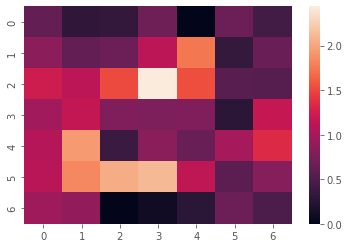

In [ ]:
sns.heatmap(x_en2[:, :, 0].detach().to("cpu"))

In [ ]:
x_ae = model(imgs.to(device)) 

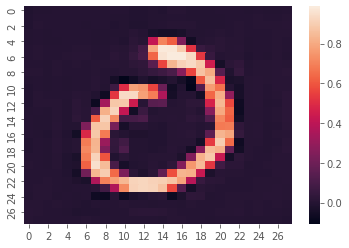

In [ ]:
sns.heatmap(x_ae[0].permute(1,2,0).detach().to("cpu")[:,:,0])